# Symbolic Distillation of GNNs Demo

In this demo, we reproduce the pipeline from the paper [*Discovering Symbolic Models from Deep Learning with Inductive Biases*](https://arxiv.org/abs/2006.11287) by Cranmer et al. (2020). In this paper, the authors train Graph Neural Networks (GNNs) on n-body system particle data (input variables are particle features; target variables are particle accerelations). \
By approximating the edge model with an analytic equation using symbolic regression, it is possible to derive the true interaction force between particles.\
In this reproduction, we use [SymTorch](https://symtorch.readthedocs.io/en/latest/) to perform the symbolic regression on the edge model. We introduce a new way of encouraging sparsity in the model representation by using SymTorch's pruning functionality.

The SymTorch functionality shown in this demo include:
* Wrapping an MLP with the `MLP_SR` class
* Creating and training a Pruning MLP within a GNN
* Approximating MLPs with symbolic expressions
* Using variable transforms
* Saving and loading models (beta)

# Set up

Firstly, make sure to set up GPU usage on this notebook: Runtime -> Change runtime type -> T4 GPU.

Mount your drive to the notebook and set up the project directory where we will save our models. Everything is going to save in a directory in your drive called `symtorch_symbolic_distillation_GNNs_demo`.

In [ ]:
# ===== PROJECT SETUP =====
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
# Set project directory (adjust path to match your folder structure)

project_dir = '/content/drive/MyDrive/symtorch_symbolic_disillation_GNNs_demo'
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)

print(f"Working directory: {os.getcwd()}")
print(f"Files in project folder: {os.listdir('.')}")

# Now your saved models will be in your project folder
script_dir = project_dir

Mounted at /content/drive
Working directory: /content/drive/MyDrive/symtorch_symbolic_disillation_GNNs_demo
Files in project folder: ['simulations', 'datasets', '__pycache__', 'train_val_test_data', 'model_weights', 'plot_linear_rep.py', 'pruning_experiments.py', 'linrepr_plots', 'pysr_objects', 'symtorch_data', 'model.py', 'utils.py', 'symtorch_model_pytorch.pth', 'symtorch_model_metadata.pkl', 'symtorch_model_regressor_dim0.pkl', 'symtorch_model_regressor_dim1.pkl']


Import the required libraries.

In [ ]:
!pip install torch-geometric accelerate wandb celluloid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
!pip install torch-symbolic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 3.7 MB/s eta 0:00:00


Fetch the relevent scripts from the project repository.

In [ ]:
!mkdir -p simulations
!wget https://raw.githubusercontent.com/elizabethsztan/SymTorch_symbolic_distillation_GNNs/main/simulations/simulate.py -O simulations/simulate.py
!wget https://raw.githubusercontent.com/elizabethsztan/SymTorch_symbolic_distillation_GNNs/main/simulations/generate_data.py -O simulations/generate_data.py
!wget https://raw.githubusercontent.com/elizabethsztan/SymTorch_symbolic_distillation_GNNs/main/model.py -O model.py
!wget https://raw.githubusercontent.com/elizabethsztan/SymTorch_symbolic_distillation_GNNs/main/utils.py -O utils.py

--2025-08-14 06:07:08--  https://raw.githubusercontent.com/elizabethsztan/SymTorch_symbolic_distillation_GNNs/main/simulations/simulate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9846 (9.6K) [text/plain]
Saving to: ‘simulations/simulate.py’

simulations/simulat 100%[===================>]   9.62K  --.-KB/s    in 0.001s  

2025-08-14 06:07:09 (17.8 MB/s) - ‘simulations/simulate.py’ saved [9846/9846]

--2025-08-14 06:07:09--  https://raw.githubusercontent.com/elizabethsztan/SymTorch_symbolic_distillation_GNNs/main/simulations/generate_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 

# Generate the dataset

The dataset that we are training on consists of particle data. We use the original code from Cranmer et al. To run n-body simulations and sample from these simulations.\
We have four different dataset consisting of four particles interacting under the following force laws:


*   Charge; $\mathbf{F} = \frac{q_1q_2}{r^2} \mathbf{\hat{r}}$
*   $r^{-1}$; $\mathbf{F} = -\frac{m_1m_2}{r} \mathbf{\hat{r}}$
* $r^{-2}$; $\mathbf{F} = -\frac{m_1m_2}{r^2} \mathbf{\hat{r}}$
* Spring; $-(r-1)\mathbf{\hat{r}}$



We need to generate the dataset. Choose which simulation you want to run.

In [ ]:
sim = 'spring' #change to either 'charge', 'r1', 'r2', 'spring'

Run the below cell to generate data. This does not take very long. The dataset will be saved in the $\texttt{datasets}$ folder.\
By default, we always use four particles in two dimensions.

In [ ]:
!python3 simulations/generate_data.py --sim $sim --save

The dataset consists of


*   Input variables: particle features $\mathbf{v}_i = [x_i, y_i, \dot{x}_i, \dot{y}_i, q_i, m_i]$
*   Target variable: instantaneous accelerations $\mathbf{a}_i=[\ddot{x}_i, \ddot{y}_i]$



# Run the models

We train GNNs on the dataset. In our GNN, each node represents a particle, and because all of the particles interact with each other, we have a fully connected graph. Our GNN consists of two MLPs: the edge model and the node model.


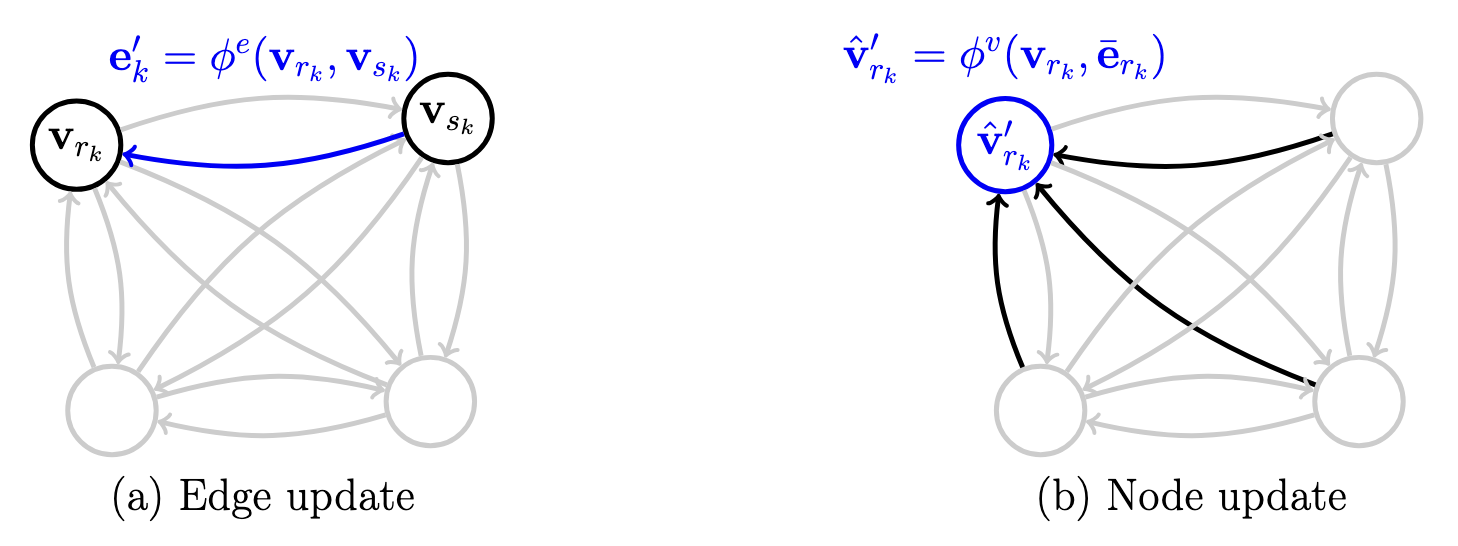

(Figure is adapted from [Battaglia et al.](https://arxiv.org/abs/1806.01261) (2018))

The edge model, $\phi^e$, takes the features of two connected nodes as input and outputs an edge message for edge $k$, $\mathbf{e}_k$,

$\mathbf{e}_k' = \phi^e (\mathbf{v}_{r_k}, \mathbf{v}_{s_k})$

where $\mathbf{v}_{r_k}$ and $\mathbf{v}_{r_k}$ denote the node features of the recieving particle and sending particles, respectively.

The messages incoming to a recieving particle are aggregated via an elementwise summation,

$\mathbf{\bar{e}}_{r_k} = \sum_{j\neq r_k} \phi^e (\mathbf{v}_{r_k}, \mathbf{v}_{j}) $

and the inputs to the node model are the aggregated messages to a recieving node and the recieving node features. The node model outputs the predictions of the accelerations of the particle.

In [ ]:
from model import *
from utils import *

[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Locating Julia ^1.10.3
[juliapkg] Using Julia 1.11.5 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Writing Project.toml:
             [deps]
             PythonCall = "6099a3de-0909-46bc-b1f4-468b9a2dfc0d"
             OpenSSL_jll = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
             SymbolicRegression = "8254be44-1295-4e6a-a16d-46603ac705cb"
             Serialization = "9e88b42a-f829-5b0c-bbe9-9e923198166b"
             [compat]
             PythonCall = "=0.9.26"
             OpenSSL_jll = "~3.0"
             SymbolicRegression = "~1.11"
             Serialization = "^1"
[juliapkg] Installing packages:
             import Pkg
             

In [ ]:
#These are the different locations for where the datasets are saved

dataset_locations = {
    'charge': 'datasets/charge_n=4_dim=2_nt=1000_dt=0.001.pt',
    'r1': 'datasets/r1_n=4_dim=2_nt=1000_dt=0.005.pt',
    'r2': 'datasets/r2_n=4_dim=2_nt=1000_dt=0.001.pt',
    'spring': 'datasets/spring_n=4_dim=2_nt=1000_dt=0.01.pt',
}

In [ ]:
#create the train, test and validation sets
train_data, val_data, test_data = load_and_process(dataset_locations[sim], seed=290402)

Choose the model type that you want to run.

## Model variations

It can be mathematically shown that, for a GNN trained to predict accelerations from particle data, the edge messages are linear combinations of true forces if the dimensionality of the edge message matches that of the system. Hence, we want to encourage sparsity in the edge model and we train several variations of the GNN for this.



*   **Standard**: no regularisation to encourage sparsity (dimension of messages = 100)
*   **Bottleneck**: constrain dimensionality of messages to that of the system (2)
*   **L1**: add an L1 regularisation of the edge messages to the loss,

  $\propto \sum_k |\mathbf{e}_k|$


* **KL**: the edge model now outputs the mean and log-variance of the messages, defining a Gaussian probability distribution on each message dimension

  $\mathbf{e}_k' \sim N (\mathbf{\mu}_k', \text{diag}[\mathbf{\sigma}_k'^2]) $ where $\mathbf{\mu}_k' = \phi^e_\mu $ and $\mathbf{\sigma}_k'^2 = \text{exp}(\phi^e_{\mathbf{\sigma}_k'^2} )$

  We add a regularisation term to the loss that is equal to the KL divergence between the defined probability distribution on the messages and a standard normal (edge model output dimensionality doubles to 200)

* **Pruning**: incrementally reduce the the dimensionality of the edge messages by zero-masking the 'unimportant' dimensions. The unimportant dimensions are chosen by passing a subset of the validation set through the edge model and choosing those with the lowest standard deviation across the datapoints (see the Pruning demo).



In [ ]:
model_type = 'bottleneck' #change to either 'standard', 'bottleneck', 'L1', 'KL', 'pruning'

We can train for a small number of epochs (equivalent to 330k optimiser steps) for sake of time. With 30 epochs and below, we use the OneCycleLR scheduler for fast training.
For the results in the project report, we trained for 200 epochs (1.1 million steps). You can change the below to 200 epochs and the scheduler will automatically change to Cosine Annealing.

In [ ]:
epochs = 30

If you want to turn on $\texttt{wandb}$ logging, you need to log in first. Uncomment the cell below.

In [ ]:
#! wandb login

Train the model. This should take around 30 mins but it saves so we can access the model weights later.

In [ ]:
model = create_model(model_type = model_type)

#if it's the pruning model we have to set the schedule
if model_type == 'pruning':
    model.edge_model.set_schedule(epochs, decay_rate='cosine', end_epoch_frac=0.65)
model = train(model, train_data=train_data, val_data=val_data, dataset_name = sim, num_epoch=epochs,
              save=True, wandb_log=False) #turn wandb_log = True if you want to log using wandb

The model weights and also the `.json` metrics file will be saved at `model_weights/sim/model_type` in this demo folder. Let's load the model now and analyse the messages.

# Plot the linear combination of forces

*This section can be skipped if you are only interested in how to use the `symtorch` package.*

Recall that for a trained GNN, the edge messages are just linear transformations of the true forces. To test this, we can perform a linear regression to fit the true forces to the (two best) messages and calculate the $R^2$ score to evaluate the fit.

To pick the best messages:

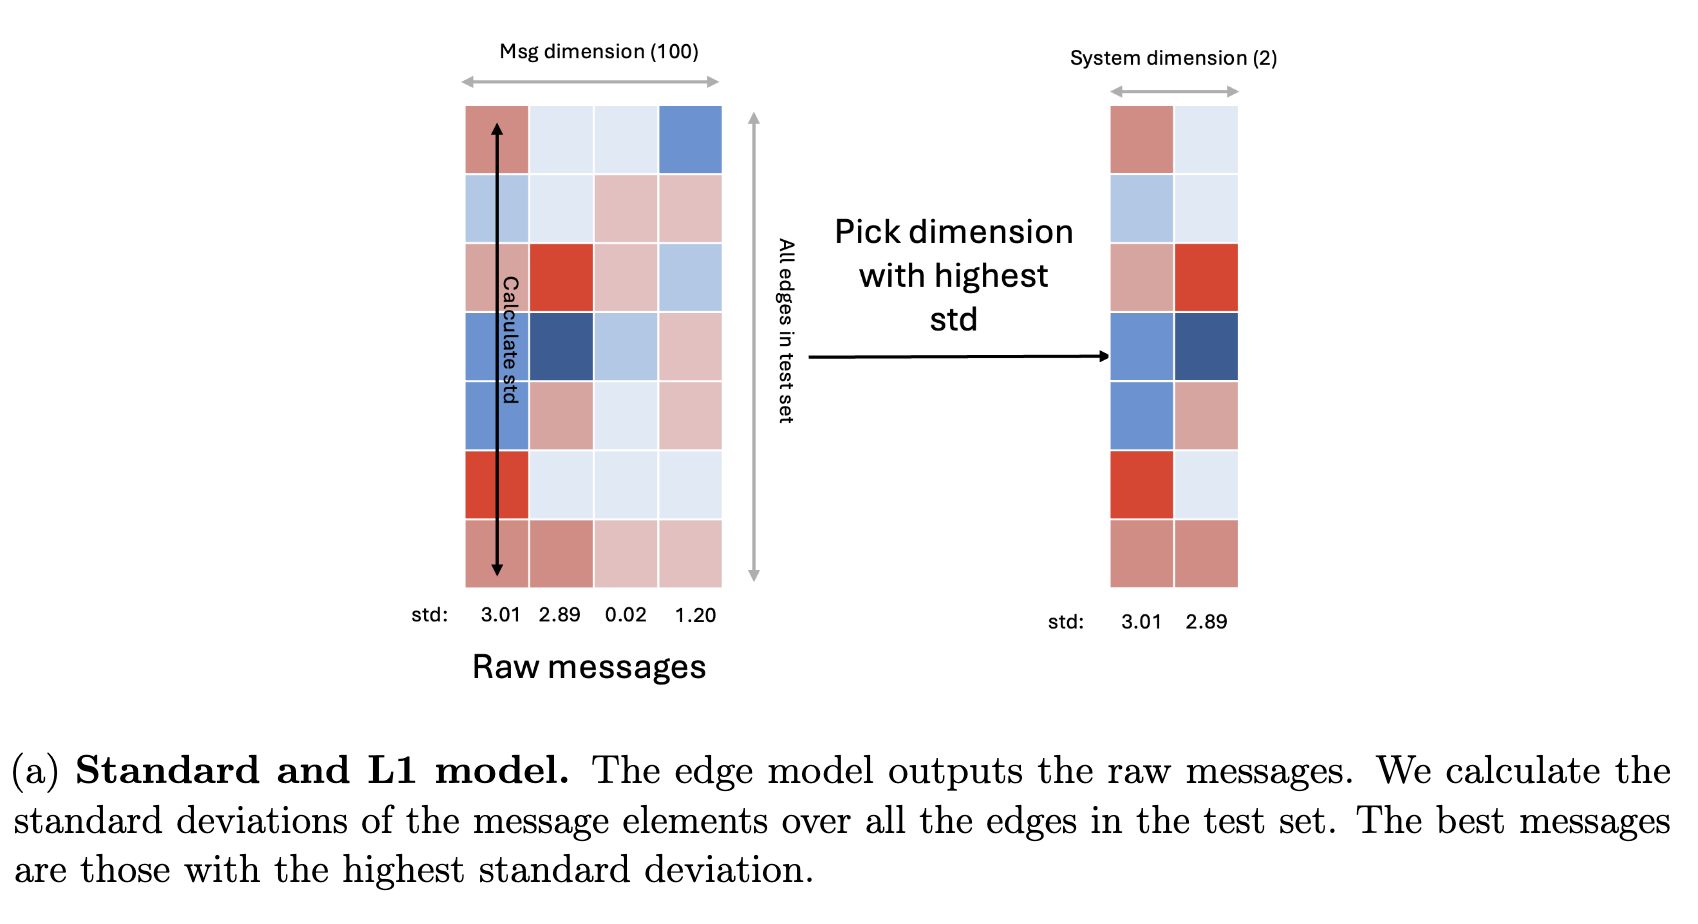

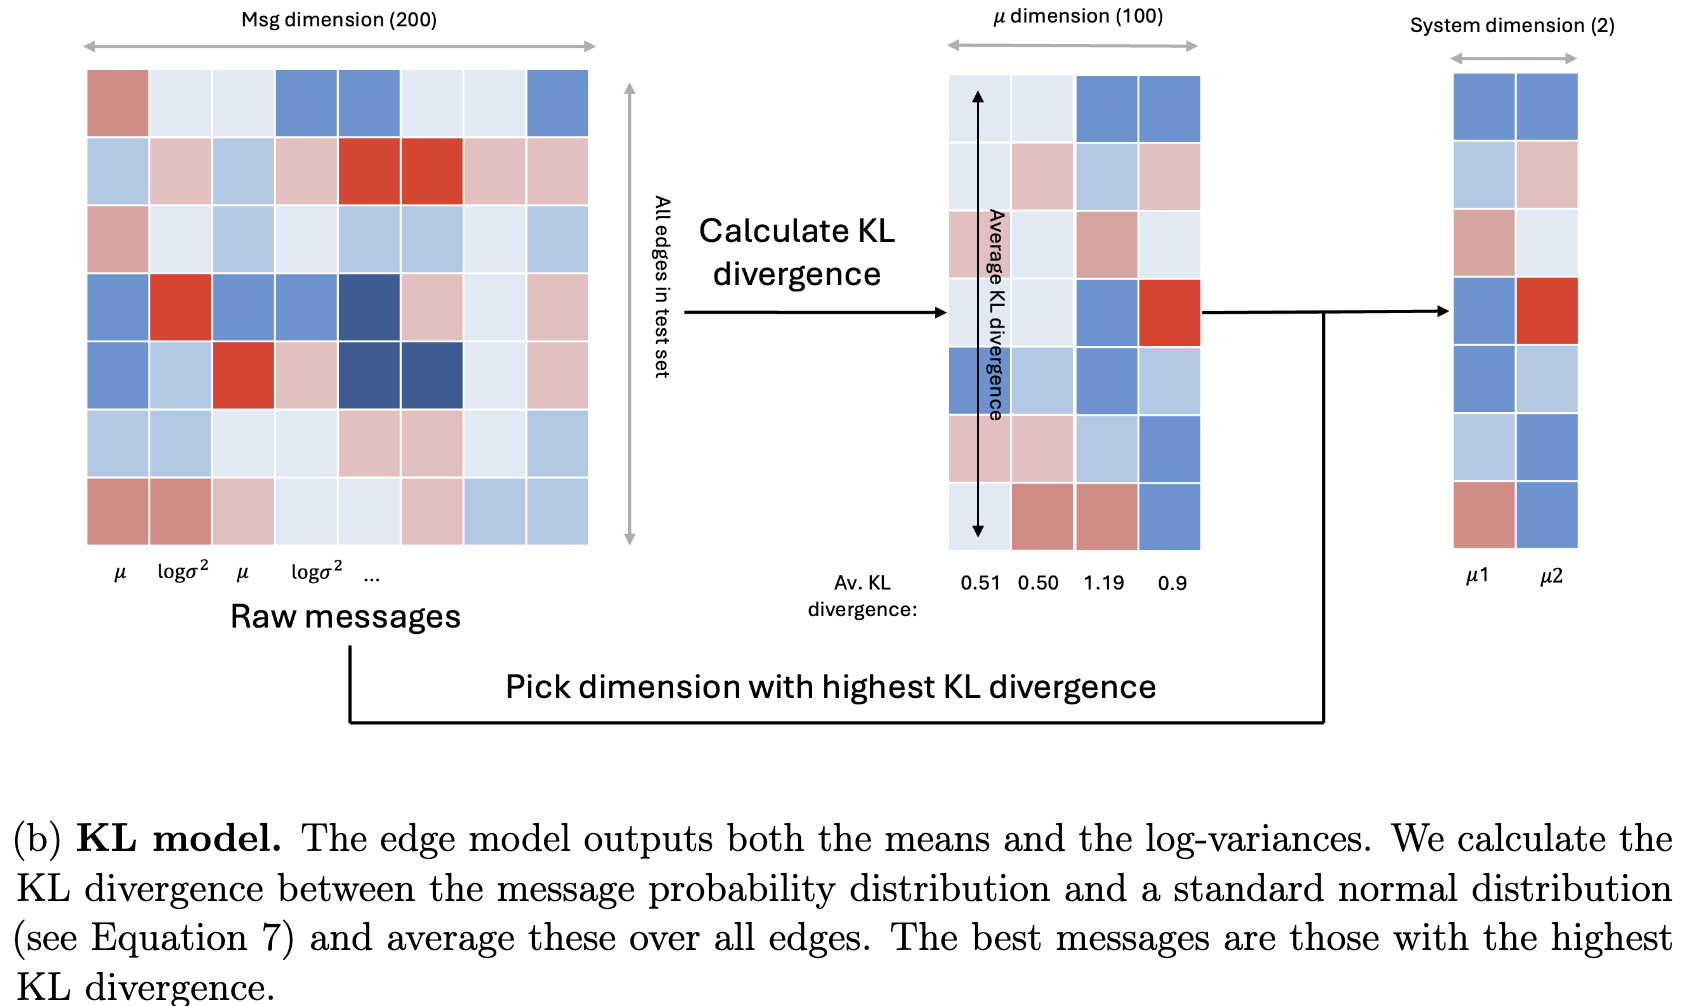

Load the model.

In [ ]:
model = load_model(sim, model_type, epochs)

Model loaded successfully.


Get the code to fit and plot the linear combination of true forces to the messages.

In [ ]:
!wget https://raw.githubusercontent.com/elizabethsztan/SymTorch_symbolic_distillation_GNNs/main/plot_linear_rep.py -O plot_linear_rep.py
!wget https://raw.githubusercontent.com/elizabethsztan/SymTorch_symbolic_distillation_GNNs/main/pruning_experiments.py -O pruning_experiments.py

In [ ]:
from plot_linear_rep import *

The following code will
1. Pass the test set through the trained model and obtain the messages from the outputs of the edge model.
2. Pick the two best message elements (for standard and L1, this if the elements with the highest std. For KL, these are elements with the highest KL divergence. For pruning and bottleneck, there are only two elements).
3. Perform a linear regression on the true forces in the $x$ and $y$ direction and to fit the two most important message elements. One linear regression includes all points, the other ignores the worst 10% of outliers (robust fit).
4. Get the $R^2$ value of both fits. For the robust fit, we again ignore the outliers for calculating $R^2$.

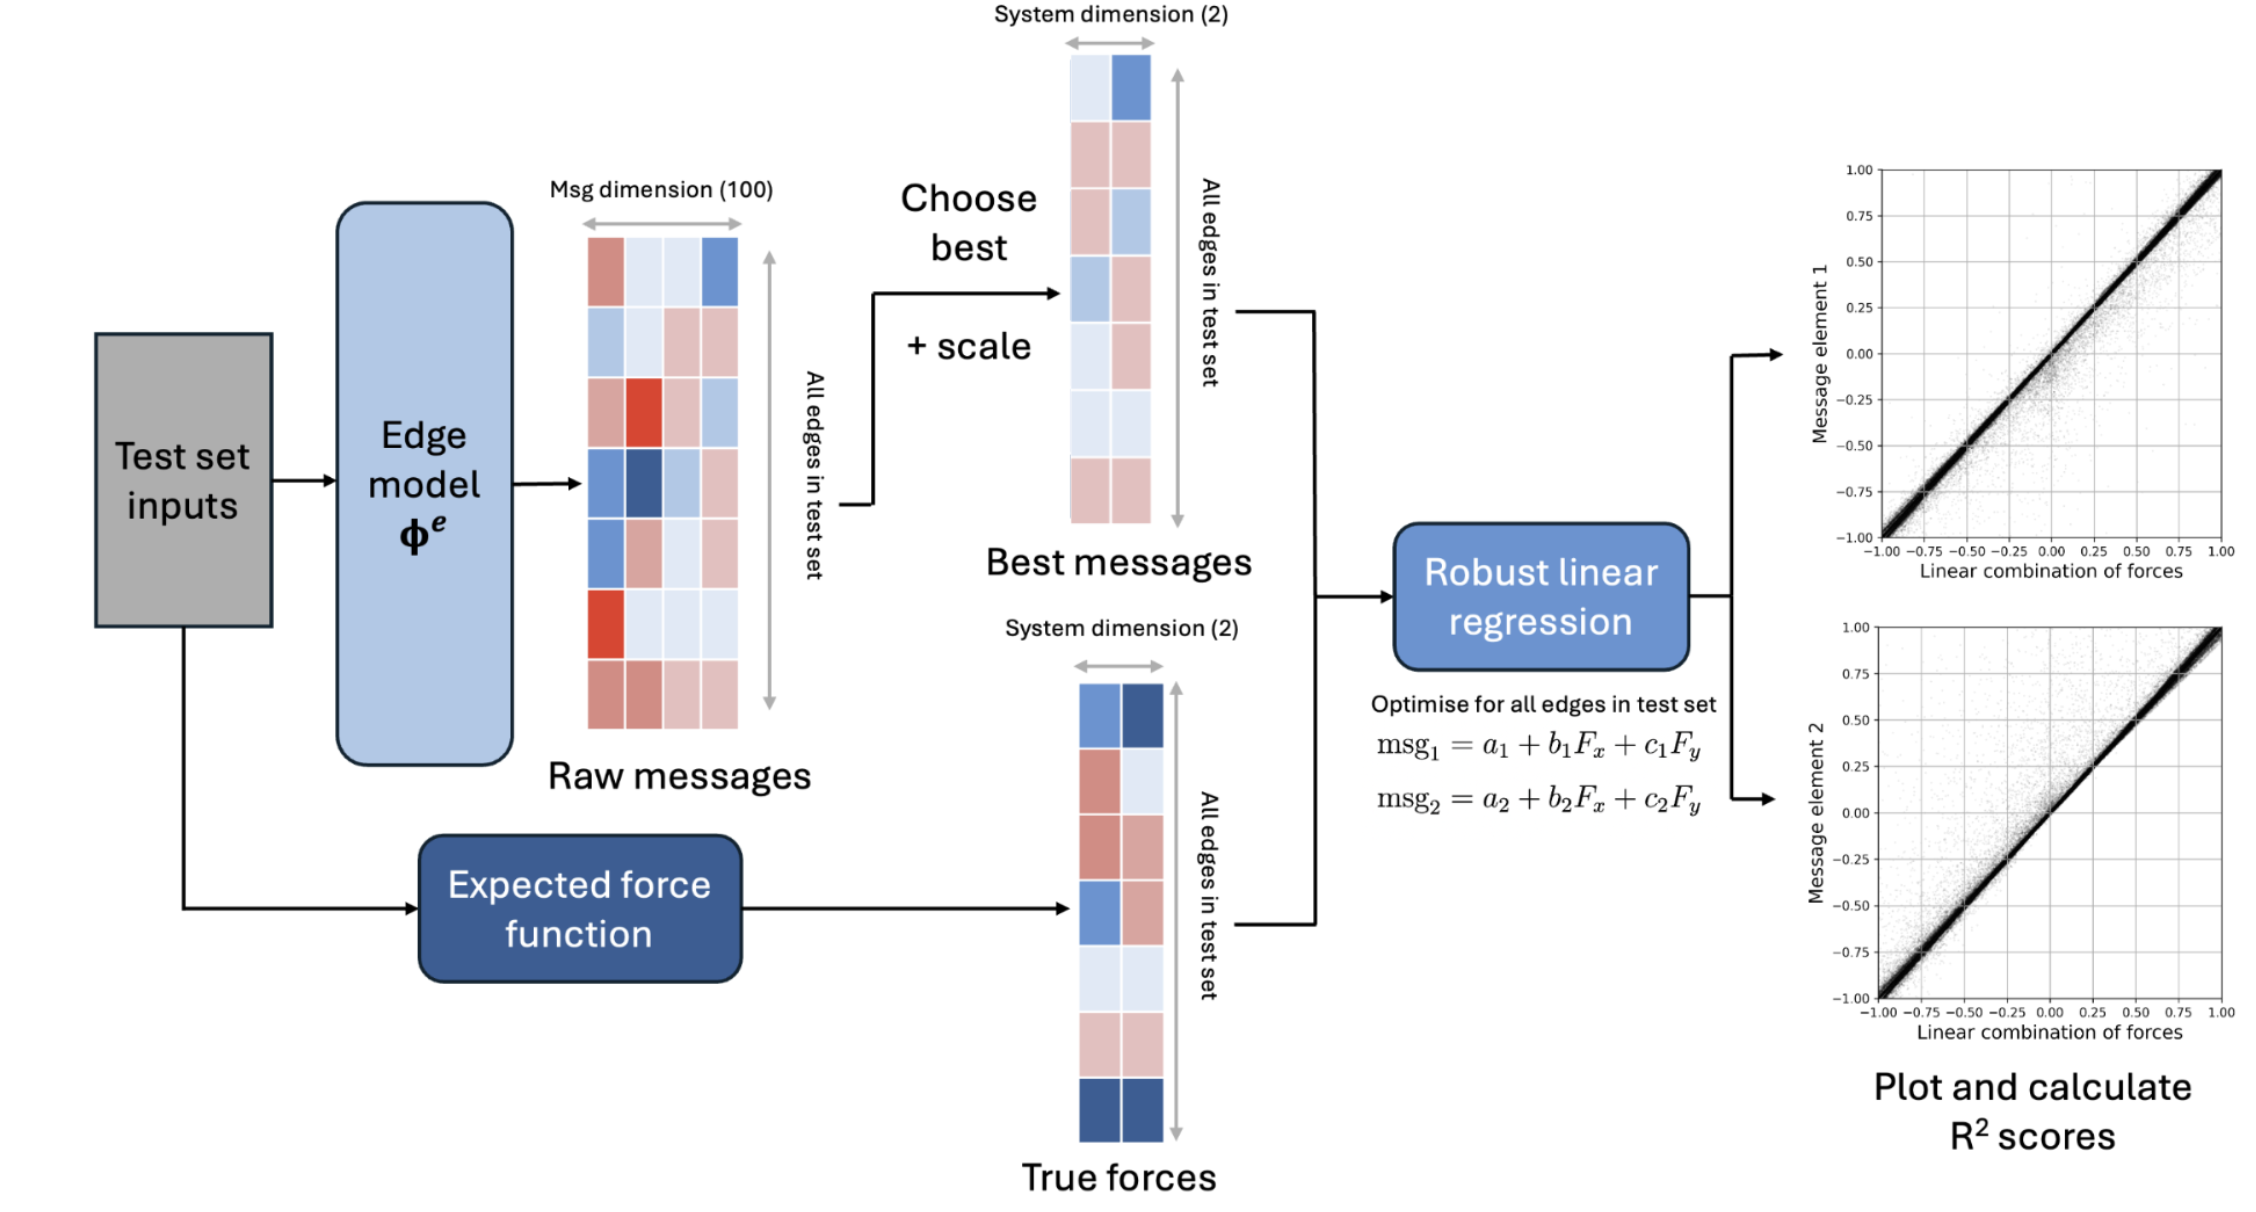


In [ ]:
r2_scores_tuple, fig = plot_linear_representation(model, test_data, sim, model_type, epochs)

The first row in the above plot is the linear fit without outliers removed and the second one includes outliers.

In [ ]:
print(f'R2 score for messages without outliers: {r2_scores_tuple[0]}')
print(f'R2 score for messages with outliers: {r2_scores_tuple[1]}')

# Symbolic regression

To perform the symbolic regression, we need to wrap the edge models of the models with the `MLP_SR` wrapper from `symtorch`. \
The pruning models are already a `symtorch.toolkit.Pruning_MLP` class, which has in-built interpretation methods.

In [ ]:
from symtorch import MLP_SR

These are the forms of the equations that we would expect for the different simulations.

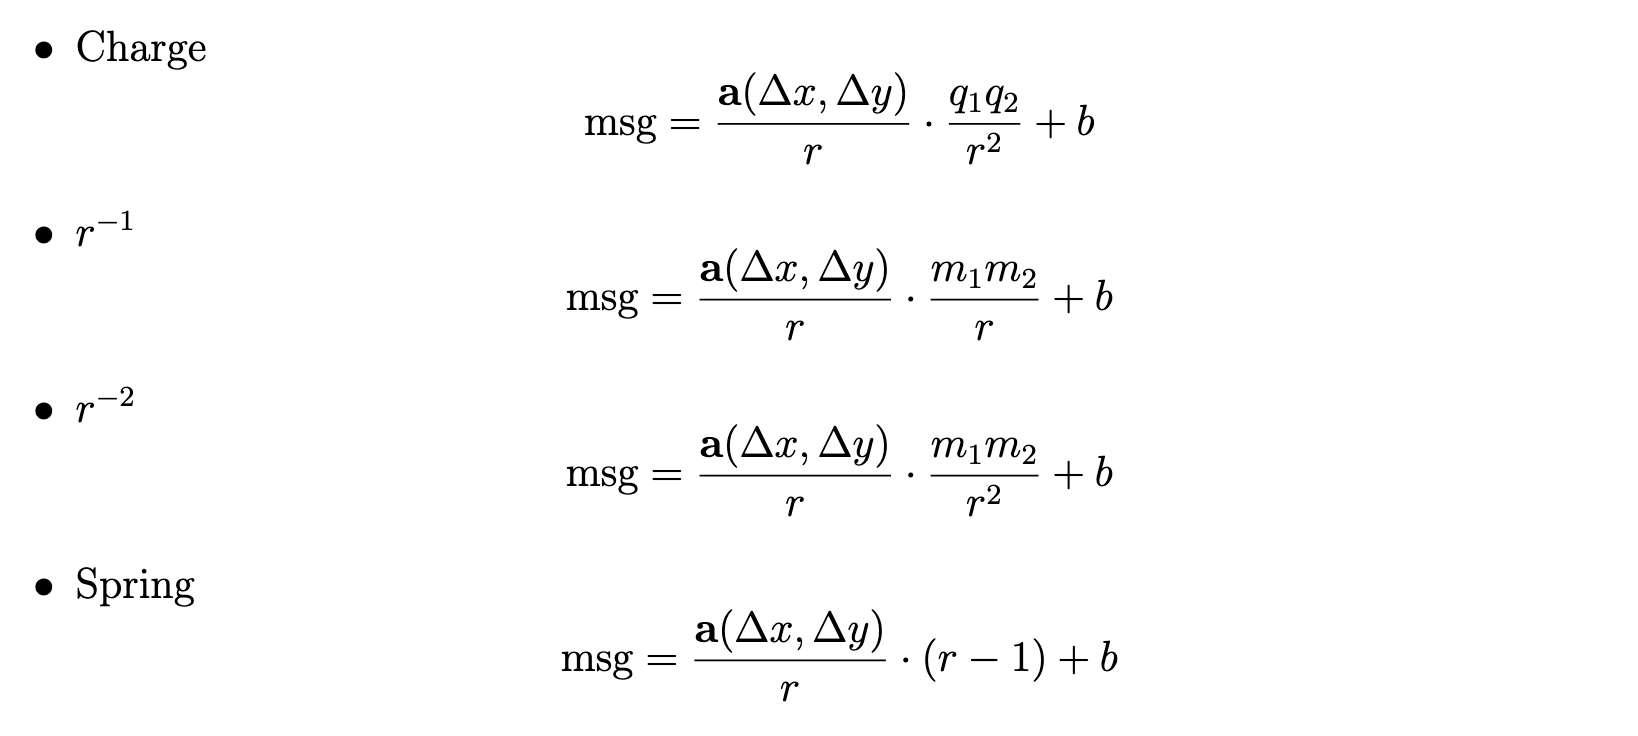

In [ ]:
# Wrap the model with the MLP_SR wrapper if it's not a pruning model
if model_type != 'pruning':
    model.edge_model = MLP_SR(model.edge_model, mlp_name=model_type)

For the standard, L1 and KL models, we need to find the two most important message dimensions in the same way as before (the dimensions with the highest standard deviation across the test set for the standard and L1 models, and the dimensions with the highest KL divergence for the KL models).

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from model import get_edge_index

# Prepare test data for edge feature extraction
X_test, y_test = test_data
edge_index = get_edge_index(X_test.shape[1])  # Full connectivity graph

# Create DataLoader for batch processing
dataset = DataLoader(
    [Data(x=X_test[i], edge_index=edge_index, y=y_test[i]) for i in range(len(X_test))],
    batch_size=len(X_test),
    shuffle=False)

# Extract edge features by concatenating source and target node features
all_inputs = []
for datapoint in dataset:
    source_nodes = datapoint.x[datapoint.edge_index[0]]  # Source node features
    target_nodes = datapoint.x[datapoint.edge_index[1]]  # Target node features
    x = torch.cat((source_nodes, target_nodes), dim=1)   # Concatenate for edge features
    all_inputs.append(x)
all_inputs = torch.cat(all_inputs, dim=0)  # Shape: [num_edges_total, 2*node_dim]

In [ ]:
import numpy as np

if model_type == 'standard' or model_type == 'L1':
    # For standard models, use all message dimensions
    important_dims_info = model.edge_model.get_importance(all_inputs)
    important_dims = important_dims_info['importance']

    dim0 = important_dims[0]
    dim1 = important_dims[1]

elif model_type == 'KL':
    # For KL models, extract mean components from variational output
    raw_outputs = model.edge_model(all_inputs).detach().numpy()
    messages = raw_outputs[:, 0::2]  # Extract mean components (every other element)
    logvars = raw_outputs[:, 1::2]

    KL_div =  (np.exp(logvars) + messages**2 - logvars)/2
    KL_mean = KL_div.mean(axis=0)
    most_important = np.argsort(KL_mean)[-2:]
    msgs_to_compare = messages[:, most_important]
    dim0 = msgs_to_compare[0] * 2
    dim1 = msgs_to_compare[1] * 2 # Because the message dims are even

(In the KL model, the mean of the messages are the even outputs of the edge model and the logvar are the odd outputs).

We can input transformations of the input variables of the edge model to the symbolic regression for efficiency purposes.

In [ ]:
# Input format: [x1, y1, vx1, vy1, q1, m1, x2, y2, vx2, vy2, q2, m2]
variable_transforms = [
    lambda x: x[:, 0] - x[:, 6],      # dx = x1 - x2 (relative position x)
    lambda x: x[:, 1] - x[:, 7],      # dy = y1 - y2 (relative position y)
    lambda x: torch.sqrt((x[:, 0] - x[:, 6])**2 + (x[:, 1] - x[:, 7])**2) + 1e-2,  # r = distance + small epsilon
    lambda x: x[:, 4],                # q1 (charge of particle 1)
    lambda x: x[:, 10],               # q2 (charge of particle 2)
    lambda x: x[:, 5],                # m1 (mass of particle 1)
    lambda x: x[:, 11]                # m2 (mass of particle 2)
]
variable_names = ['dx', 'dy', 'r', 'q_one', 'q_two', 'm_one', 'm_two']

Pass in only a subset of the input data to the symbolic regression. We use 5000 datapoints.

In [ ]:
# Sample subset of data for symbolic regression (for computational efficiency)
np.random.seed(290402)  # Fixed seed for reproducibility
idx = np.random.choice(len(all_inputs), size=5_000, replace=False)
inputs_subset = all_inputs[idx]

Now, we can use the `.distill` method to run symbolic regression on the inputs and outputs of our edge models.

In [ ]:
niterations = 200 # This should be 7000 but reduced to make quicker
save_path = f'pysr_objects/{dataset}/{niterations}'
os.makedirs(save_path, exist_ok=True)

# For models with multiple dimensions, analyse top 2 most important dimensions
sr_params = {'niterations':niterations,
                'parsimony':0.05,                    # Simplicity preference
                'complexity_of_constants':1,         # Penalty for complex constants
                'maxsize': 25,                        # Max expression size
                'elementwise_loss':"loss(prediction, target) = abs(prediction - target)",
                'batching':True,
                'unary_operators':["inv(x) = 1/x", "exp", "log"],
                'constraints':{'exp': (1), 'log': (1)},
                'complexity_of_operators':{'exp': 3, 'sin': 3, 'log': 3}}

fit_params = {'variable_names':variable_names}

# Run symbolic regression on selected message dimensions
if model_type == 'standard' or model_type == 'L1' or model_type == 'KL':


    # First dimension (most important)
    result = model.edge_model.distill(
        inputs_subset,
        output_dim=dim0,
        variable_transforms=variable_transforms,
        sr_params = sr_params,
        fit_params = fit_params,
        save_path=save_path)

    # Second dimension (second most important)
    result = model.edge_model.distill(
        inputs_subset,
        output_dim=dim1,
        variable_transforms=variable_transforms,
        sr_params = sr_params,
        fit_params = fit_params,
        save_path=save_path
    )

else:
    # For bottleneck and pruning models, analyse all available dimensions
    result = model.edge_model.distill(
        inputs_subset,
        variable_transforms=variable_transforms,
        sr_params = sr_params,
        fit_params = fit_params,
        save_path=save_path
    )

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
INFO:pysr.sr:Compiling Julia backend...


🔄 Applied 7 variable transformations
   Variable names: ['dx', 'dy', 'r', 'q_one', 'q_two', 'm_one', 'm_two']
🛠️ Running SR on output dimension 0 of 1


[ Info: Started!



Expressions evaluated per second: 1.330e+03
Progress: 138 / 6200 total iterations (2.226%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.679e-01  0.000e+00  y = 0.025071
3           6.215e-01  1.058e-01  y = dx * 0.49412
5           4.600e-01  1.505e-01  y = (dx + dy) * 0.52001
7           4.302e-01  3.350e-02  y = (dy * 0.42368) + (0.64371 * dx)
9           2.951e-01  1.884e-01  y = ((dy + dx) * 0.35287) * (r + -0.38971)
10          1.649e-01  5.821e-01  y = log(r) * ((dy * 0.73434) + dx)
18          1.631e-01  1.395e-03  y = ((((dy + (dx * 0.045231)) * 0.70627) + dx) + 0.045564)...
                                       * inv(inv(log(r)))
───────────────────────────────────────────────────────────────────────────────────────────────────
══════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.637e-01  0.000e+00  y = dx
3           6.215e-01  1.030e-01  y = dx * 0.49596
5           4.600e-01  1.505e-01  y = (dy + dx) * 0.51858
7           3.076e-01  2.011e-01  y = (r * (dy + dx)) * 0.27786
8           2.524e-01  1.979e-01  y = log(r) * (dx + dy)
9           2.508e-01  6.309e-03  y = (dx + (dy * 0.70997)) * (r * 0.33728)
10          1.615e-01  4.401e-01  y = (dy + dx) * ((inv(r) + -0.99923) * -1.261)
12          7.688e-02  3.711e-01  y = (dy + (dx * 1.4162)) * ((inv(r) + -0.99923) * -1.0628)
14          5.966e-02  1.268e-01  y = (((dx * 1.4301) + dy) * ((inv(r) + -0.9975) * -1.0791)...
                                      ) + 0.035055
16          4.286e-02  1.654e-01  y = (((m_one * 0.060147) + -1.1346) * (inv(r) + -0.99752))...
                                       * (dy + (dx * 1.4164))
18          4.286e-02  1.031e-0

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


  - pysr_objects/<torch_geometric.loader.dataloader.DataLoader object at 0x785cd8bca150>/200/bottleneck/dim0_1755011264/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 2.460e+02
Progress: 67 / 6200 total iterations (1.081%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.499e-01  0.000e+00  y = -0.018139
3           5.938e-01  1.167e-01  y = dy * 0.49235
5           5.153e-01  7.091e-02  y = (dy * 0.29748) * r
6           4.571e-01  1.198e-01  y = log(r) * dy
7           4.285e-01  6.463e-02  y = dy + ((dx + dy) * -0.37027)
9           2.515e-01  2.665e-01  y = r * ((dx * -0.21555) + (dy * 0.33688))
10          1.611e-01  4.455e-01  y = log(r) * ((dx * -0.66207) + dy)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution 

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.499e-01  0.000e+00  y = -0.018139
3           5.938e-01  1.167e-01  y = 0.48685 * dy
5           5.152e-01  7.095e-02  y = (r * dy) * 0.29378
6           4.571e-01  1.197e-01  y = log(r) * dy
7           4.229e-01  7.771e-02  y = (dy + (dx * -0.67537)) * 0.60805
8           4.229e-01  7.510e-05  y = inv(1.6366) * (dy + (dx * -0.67537))
9           2.483e-01  5.327e-01  y = (r * ((dx * -0.67537) + dy)) * 0.3347
10          1.600e-01  4.392e-01  y = (dy + (dx * -0.6814)) * log(r)
12          6.629e-02  4.406e-01  y = ((dx * -0.68857) + dy) * ((inv(r) + -0.99609) * -1.463...
                                      4)
17          6.496e-02  4.064e-03  y = (((dx * -0.68419) + dy) * (inv(r + 0.11438) + 0.58503)...
                                      ) * log(r)
19          4.463e-02  1.877e-01  y = log(r) * (((0.63655 + inv(r)) + (m_one *

In [ ]:
# Save the model with the equations
os.makedirs('symtorch_data', exist_ok = True)
model.edge_model.save_model('symtorch_model')

✅ Saved PyTorch model state to symtorch_model_pytorch.pth
✅ Saved model metadata to symtorch_model_metadata.pkl
✅ Saved regressor for dimension 0 to symtorch_model_regressor_dim0.pkl
✅ Saved regressor for dimension 1 to symtorch_model_regressor_dim1.pkl
✅ Saved 2 PySR regressors
🎯 Model save complete. Created 4 files with base name: symtorch_model


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:1270: UserWarning: `extra_sympy_mappings` cannot be pickled and will be removed from the serialized instance. When loading the model, please redefine `extra_sympy_mappings` at runtime.
  warnings.warn(warn_msg)


['symtorch_model_pytorch.pth',
 'symtorch_model_metadata.pkl',
 'symtorch_model_regressor_dim0.pkl',
 'symtorch_model_regressor_dim1.pkl']

In [ ]:
# Load the model
loaded_model = MLP_SR.load_model('symtorch_model')

📂 Loading MLP_SR model: bottleneck
✅ Loaded regressor for dimension 0
✅ Loaded regressor for dimension 1
✅ Loaded 2 PySR regressors
🎯 Model loading complete: bottleneck


We cannot say what precise equation that we will reconstruct. Also reconstruction is not always possible. See the results on what simulations/model types were successful:

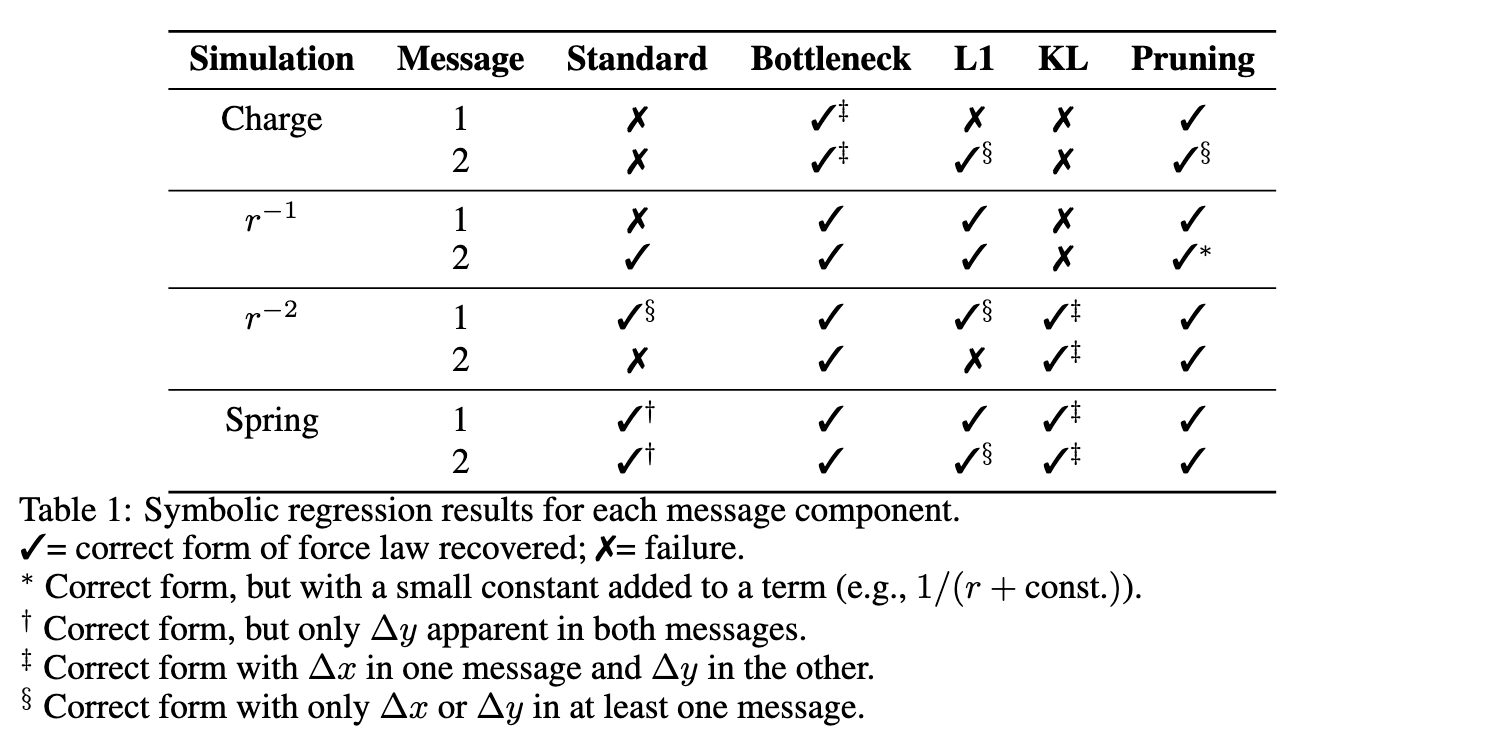